In [0]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, AveragePooling1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
import time

In [0]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    if(len(dataset) ==2):
        dataX.append(dataset[0])
        dataY.append(dataset[1,0])
        return np.array(dataX), np.array(dataY)
    #for i in range(len(dataset) - look_back - 1):
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
df = pd.read_csv("sp500.csv")
df['caldt'] = pd.to_datetime(df['caldt'], format = '%Y%m%d')
df['caldt'] =  df['caldt'].dt.strftime('%Y-%m-%d')
data = df['spindx'].values
data = data.astype('float32')
data = np.reshape(data,(-1,1))
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

df.head()

,caldt,vwretd,spindx,sprtrn
0,2009-06-01,0.025957,942.87,0.025818
1,2009-06-02,0.001893,944.74,0.001983
2,2009-06-03,-0.013036,931.76,-0.013739
3,2009-06-04,0.011331,942.46,0.011484
4,2009-06-05,-0.002298,940.09,-0.002515


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Simple train-test split (no forward chaining)

# params
num_hidden = 64
pred = []
batch_size = 10
epochs = 2
look_back = 10

start = time.time()
# the following design is for look_back = 10
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(look_back, 1))) # output: (8, 128)
model.add(AveragePooling1D(pool_size=3, strides=1)) # output: (6, 128)
model.add(Conv1D(64, 3, activation='relu')) # output: (4, 64)
model.add(AveragePooling1D(pool_size=3, strides=1)) # output: (2, 64)
model.add(Flatten()) # output: (128)
model.add(Dense(num_hidden, activation='relu')) # output: (num_hidden, )
model.add(Dense(1)) # output: (1, )

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

train_split = 0.67
train_size = int(len(data) * train_split)
train, test = data[:train_size, :], data[train_size:, :]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX, testX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1)), testX.reshape((testX.shape[0], testX.shape[1], 1))
print(trainX.shape, testX.shape)
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

testPredict = model.predict(testX)

# invert predictions
testPredict = scaler.inverse_transform(testPredict)
pred.append(testPredict)
end = time.time()

print("Total time: {}".format(end - start))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 8, 128)            512       
_________________________________________________________________
average_pooling1d_17 (Averag (None, 6, 128)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 4, 64)             24640     
_________________________________________________________________
average_pooling1d_18 (Averag (None, 2, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 1)               

In [0]:
predictions = np.reshape(pred, (-1, 1))
print(testY.shape)
testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape((-1, 1))), predictions))
print('Test Score: %.2f RMSE' % (testScore))

(870,)
Test Score: 44.17 RMSE


(870, 1)


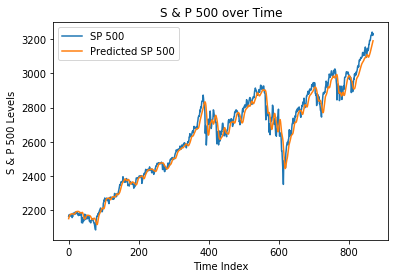

In [0]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
print(predictions.shape)
start_ind = train_size + look_back
testPredictPlot[start_ind : start_ind + len(predictions), :] = predictions
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data[start_ind:, :]), label = 'SP 500')
plt.plot(predictions, label = 'Predicted SP 500')
plt.ylabel('S & P 500 Levels')
plt.xlabel('Time Index')
plt.title('S & P 500 over Time')
plt.legend()
plt.show()

In [0]:
# Forward chaining!

pred = [] # at the end, append to prediction
num_hidden = 64
look_back = 10
batch_size = 10
epochs = 3

end_index = len(data) - 1 - look_back
begin_index = int(0.67 * end_index) #10# 10
start = time.time()
for i in range(begin_index, end_index + 1):
    print('Forward chaining up to index: {}'.format(i))
    train, test = data[0:i,:], data[i:i+look_back+1, :]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # Begin model design
    # the following design is for look_back = 10
    model = Sequential()
    model.add(Conv1D(128, 3, activation='relu', input_shape=(look_back, 1))) # output: (8, 128)
    model.add(AveragePooling1D(pool_size=3, strides=1)) # output: (6, 128)
    model.add(Conv1D(64, 3, activation='relu')) # output: (4, 64)
    model.add(AveragePooling1D(pool_size=3, strides=1)) # output: (2, 64)
    model.add(Flatten()) # output: (128)
    model.add(Dense(num_hidden, activation='relu')) # output: (num_hidden, )
    model.add(Dense(1)) # output: (1, )
    # End model design

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    testPredict = model.predict(testX)

    print('difference: {}'.format(np.abs(testPredict - testY)))

    # invert predictions
    testPredict = scaler.inverse_transform(testPredict)
    pred.append(testPredict)

    # clear
    K.clear_session()

end = time.time()
print('Total time: {}'.format(end - start))

Streaming output truncated to the last 5000 lines.
2021/2021 [==============================] - 1s 493us/step - loss: 0.0025
Epoch 2/3
2021/2021 [==============================] - 1s 377us/step - loss: 1.7703e-04
Epoch 3/3
2021/2021 [==============================] - 1s 364us/step - loss: 1.6503e-04
difference: [[0.00384593]]
Forward chaining up to index: 2032
Epoch 1/3
2022/2022 [==============================] - 1s 522us/step - loss: 0.0031
Epoch 2/3
2022/2022 [==============================] - 1s 368us/step - loss: 1.7738e-04
Epoch 3/3
2022/2022 [==============================] - 1s 380us/step - loss: 1.6158e-04
difference: [[0.00419134]]
Forward chaining up to index: 2033
Epoch 1/3
2023/2023 [==============================] - 1s 529us/step - loss: 0.0022
Epoch 2/3
2023/2023 [==============================] - 1s 369us/step - loss: 1.7907e-04
Epoch 3/3
2023/2023 [==============================] - 1s 373us/step - loss: 1.7055e-04
difference: [[0.01104289]]
Forward chaining up to index

In [0]:
predictions = np.reshape(pred, (-1, 1))
print(predictions.shape)
testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(data[begin_index + look_back: end_index + look_back + 1]), predictions))
print('Test Score: %.2f RMSE' % (testScore))

(878, 1)
Test Score: 50.10 RMSE


(878, 1)


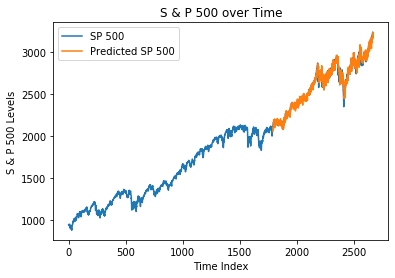

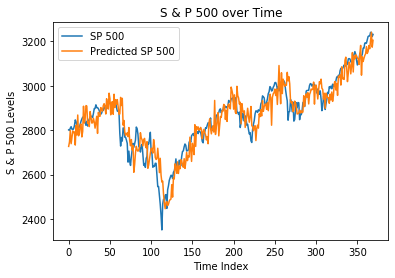

In [0]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
print(predictions.shape)

testPredictPlot[begin_index + look_back: end_index + look_back + 1, :] = predictions
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data), label = 'SP 500')
plt.plot(testPredictPlot, label = 'Predicted SP 500')
plt.ylabel('S & P 500 Levels')
plt.xlabel('Time Index')
plt.title('S & P 500 over Time')
plt.legend()
plt.show()

# plot the last n observations
n = 370
plt.plot(scaler.inverse_transform(data[-n:, :]), label = 'SP 500')
plt.plot(testPredictPlot[-n:, :], label = 'Predicted SP 500')
plt.ylabel('S & P 500 Levels')
plt.xlabel('Time Index')
plt.title('S & P 500 over Time')
plt.legend()
plt.show()